In [ ]:
import numpy as np
from scipy import signal
from scipy.ndimage.interpolation import zoom
from matplotlib import pyplot as plt
import pandas as pd
from os import listdir
def ls(ruta = '.'):
    return listdir(ruta)

from IPython.display import Audio#reproduce el audio en colab
import librosa as lb
from python_classifier_2022.helper_code import * #codigo dado por el challenge
import seaborn as sns

In [ ]:
path_train = '../DataBase/dataset-1.0.1/training_data/'
path_db = '../DataBase/dataset-1.0.1/'

# Primer Análisis

In [ ]:
x,rate=lb.load(path_train + '14241_PV.wav',sr=None) #todas las freceuncias estan a 4000Hz
print('frecuencia de muestreo ',rate)

frecuencia de muestreo  4000


In [ ]:
x.shape

(85184,)

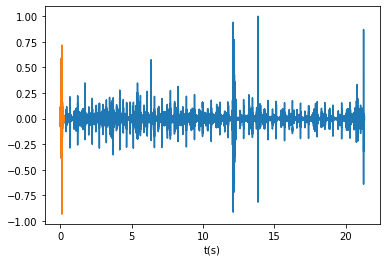

In [ ]:
plt.plot(np.linspace(0,len(x)/rate,len(x)),x)
plt.xlabel('t(s)')
plt.plot(np.linspace(0,len(x[:1000])/rate,len(x[:1000])),x[:1000])
Audio(data=x,rate=rate)

Hay ruido de fondo y por movimiento. se podrian aplicar filtros a la señal y luego hacer una normalizacion al resultado antes de sacar las caractrísticas. Dentro del filtro habra que analizar si se hace para rechazar el ruido intentando conservar la información o dejando solo pasar las bandas conocidas.

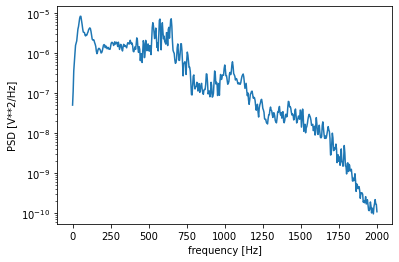

In [ ]:
f, Pxx_den = signal.welch(x, rate, nperseg=1024)
plt.semilogy(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

Señal remuestreada

In [ ]:
x,rate=lb.load(path_train + '14241_PV.wav',sr=1000)#se reportan frecuencias relevantes hasta 200 Hz, pero como tal el
#espectro pareciera estar hasta 500hz 
print('frecuencia de muestreo ',rate)

frecuencia de muestreo  1000


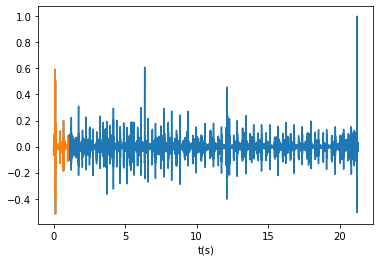

In [ ]:
x=x/np.max(x)
plt.plot(np.linspace(0,len(x)/rate,len(x)),x)
plt.xlabel('t(s)')
plt.plot(np.linspace(0,len(x[:1000])/rate,len(x[:1000])),x[:1000])
Audio(data=x,rate=rate)

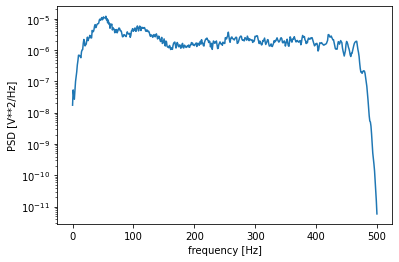

In [ ]:
f, Pxx_den = signal.welch(x, rate, nperseg=1024)
plt.semilogy(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

# Extraccion Caracteristicas

In [ ]:
def cycle_characteristics(signal,rate,window):
    '''
    Funcion para extraer caracteristicas por cada senal
    '''
    n_fft=int(rate*window) 
    hop_length=int(rate*window/2)
    S_mag,_ = lb.magphase(lb.stft(y=signal,n_fft=n_fft,hop_length=hop_length))

    mfccs=lb.feature.mfcc(y=signal, sr=rate, n_mfcc=13, n_fft=n_fft, hop_length=hop_length)
    zcr  =lb.feature.zero_crossing_rate(y=signal, frame_length=n_fft, hop_length=hop_length)#zero crossing rate
    rms  =lb.feature.rms(S=S_mag,frame_length=n_fft, hop_length=hop_length)#RMS

    sr90 =lb.feature.spectral_rolloff(y=signal, sr=rate, S=S_mag, n_fft=n_fft, hop_length=hop_length,roll_percent=0.9)
    sr10 =lb.feature.spectral_rolloff(y=signal, sr=rate, S=S_mag, n_fft=n_fft, hop_length=hop_length,roll_percent=0.1)#rolloff
    sc   =lb.feature.spectral_centroid(y=signal, S=S_mag, sr=rate, n_fft=n_fft, hop_length=hop_length)#spectral centroid

    c = np.concatenate( (mfccs,zcr,rms,sr90,sr10,sc),axis = 0 )
    c = np.concatenate( (c.min(axis=1),c.max(axis=1),np.median(c,axis=1),c.mean(axis=1),c.std(axis=1)) )
    return c

def get_specific_info(data, search_str):
  '''
  funcion creada para extrar info especifica de los .txt
  '''
    label = None
    for l in data.split('\n'):
        if l.startswith(search_str):
            try:
                label = l.split(': ')[1]
            except:
                pass
    if label is None:
        raise ValueError('error when searching for more info')
    return label
    
def get_patient_info(data,info):
    id = get_patient_id(data)
    locations = get_locations(data)
    info_v=[]
    for i in info:
        info_v.append(get_specific_info(data,i))
    return id,locations,info_v 

def get_features(data_folder,data_path,resamp,w,info):
    '''
    Parametros:
        data_folder: Ruta a la carpeta de todos los archivos
        data_path: Arcivo del paceinte especifico 
        resamp: Remuestro
        w: ventana en s para extraer las características
        info: Informacion que se quiere extraer de cada archivo, los de test no tendran algunas características
    Llamado igual al que se debe usar despues
    devuelve dos matrices, una con carateristicas de la señal y otra con las del paciente repetidas por cada locacion
    '''
    data = load_patient_data(data_path)
    id,locations,info_v  = get_patient_info(data,info)
    
    #get age
    age_group=info_v[0]
    if compare_strings(age_group, 'Neonate'):
        age = 0
    elif compare_strings(age_group, 'Infant'):
        age = 1
    elif compare_strings(age_group, 'Child'):
        age = 2
    elif compare_strings(age_group, 'Adolescent'):
        age = 3
    elif compare_strings(age_group, 'Young Adult'):
        age = 4
    else:
        age = float('nan')

    #get sex

    if compare_strings(info_v[1], 'Female'):
        sex = 0
    elif compare_strings(info_v[1], 'Male'):
        sex = 1
    else:
        sex = float('nan')
    
    #get heigth and weight
    height = np.float64(info_v[2])
    weight = np.float64(info_v[3])

    #get pregnancy status
    if compare_strings(info_v[4], 'False'):
        preg = 0
    elif compare_strings(info_v[4], 'True'):
        preg = 1
    else:
        preg = float('nan')
    recording_locations = ['AV', 'MV', 'PV', 'TV', 'Phc']
    # Optinal for create training dataset
    if len(info_v)>5:
        murmur_locs = info_v[5].split('+')
        murmur_locs_cod = np.zeros(5,dtype=int)
        murmur_most_au = np.zeros(5,dtype=int)
        for _,loc in enumerate(murmur_locs):
            if loc in recording_locations:
                murmur_locs_cod[recording_locations.index(loc)]=+1

        if info_v[6] in recording_locations:
            murmur_most_au[recording_locations.index(info_v[6])]=+1
        demo_features = np.hstack((age,sex,height,weight,preg,murmur_locs_cod,murmur_most_au))
    else:
        demo_features = np.hstack((age,sex,height,weight,preg))

    signal_features = list()

    num_locations = get_num_locations(data)
    recording_information = data.split('\n')[1:num_locations+1]

    for c,i in enumerate(locations):
        entries = recording_information[c].split(' ')
        locs = np.zeros(5,dtype=int)
        recording_file = entries[2]
        if i in recording_locations:
            locs[recording_locations.index(i)]=+1
        else:
            print('what',i)
        x,rate=lb.load(data_folder+recording_file,sr=resamp)
        x=x/np.max(np.abs(x))
        signal_features.append( np.hstack( (id,locs,cycle_characteristics(x,rate,w)) ) )

    return demo_features,signal_features

In [ ]:
from tqdm import tqdm

In [ ]:
w=0.2 #Tamaño de ventana para caracteristicas en seg
resamp=500 #Frecuencia para remuestrear la señal, probar con 1000 y con 500
c = []
info='''#Age,
#Sex,
#Height,
#Weight,
#Pregnancy status,
#Murmur locations,
#Most audible location'''.split(',\n')

patient_files = find_patient_files(path_train)
demo_data=[]
signal_data=[]
for i in tqdm(patient_files):
    current=get_features(path_train,i,resamp,w,info)
    demo_data.append(current[0])
    signal_data.extend(current[1])
#duro 3m 18s los 942 pacientes

  0%|          | 0/942 [00:00<?, ?it/s]C:\Users\Andres Romero\anaconda3\envs\data_science\lib\site-packages\librosa\util\decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
100%|██████████| 942/942 [03:09<00:00,  4.97it/s]


In [ ]:
# texto='''id,AV,MV,PV,TV,Phc,
# mfcc1 min, mfcc2 min, mfcc3 min, mfcc4 min, mfcc5 min, mfcc6 min, mfcc7 min, mfcc8 min, mfcc9 min, mfcc10 min, mfcc11 min, mfcc12 min, mfcc13 min, zcr min, rms min, sr90 min, sr10 min, sc min,
# mfcc1 max, mfcc2 max, mfcc3 max, mfcc4 max, mfcc5 max, mfcc6 max, mfcc7 max, mfcc8 max, mfcc9 max, mfcc10 max, mfcc11 max, mfcc12 max, mfcc13 max, zcr max, rms max, sr90 max, sr10 max, sc max,
# mfcc1 med, mfcc2 med, mfcc3 med, mfcc4 med, mfcc5 med, mfcc6 med, mfcc7 med, mfcc8 med, mfcc9 med, mfcc10 med, mfcc11 med, mfcc12 med, mfcc13 med, zcr med, rms med, sr90 med, sr10 med, sc med,
# mfcc1 mean, mfcc2 mean, mfcc3 mean, mfcc4 mean, mfcc5 mean, mfcc6 mean, mfcc7 mean, mfcc8 mean, mfcc9 mean, mfcc10 mean, mfcc11 mean, mfcc12 mean, mfcc13 mean, zcr mean, rms mean, sr90 mean, sr10 mean, sc mean,
# mfcc1 std, mfcc2 std, mfcc3 std, mfcc4 std, mfcc5 std, mfcc6 std, mfcc7 std, mfcc8 std, mfcc9 std, mfcc10 std, mfcc11 std, mfcc12 std, mfcc13 std, zcr std, rms std, sr90 std, sr10 std, sc std'''
# texto.replace('\n',' ')

In [ ]:
texto='''id,AV,MV,PV,TV,Phc,
mfcc1 min, mfcc2 min, mfcc3 min, mfcc4 min, mfcc5 min, mfcc6 min, mfcc7 min, mfcc8 min, mfcc9 min, mfcc10 min, mfcc11 min, mfcc12 min, mfcc13 min, zcr min, rms min, sr90 min, sr10 min, sc min,
mfcc1 max, mfcc2 max, mfcc3 max, mfcc4 max, mfcc5 max, mfcc6 max, mfcc7 max, mfcc8 max, mfcc9 max, mfcc10 max, mfcc11 max, mfcc12 max, mfcc13 max, zcr max, rms max, sr90 max, sr10 max, sc max,
mfcc1 med, mfcc2 med, mfcc3 med, mfcc4 med, mfcc5 med, mfcc6 med, mfcc7 med, mfcc8 med, mfcc9 med, mfcc10 med, mfcc11 med, mfcc12 med, mfcc13 med, zcr med, rms med, sr90 med, sr10 med, sc med,
mfcc1 mean, mfcc2 mean, mfcc3 mean, mfcc4 mean, mfcc5 mean, mfcc6 mean, mfcc7 mean, mfcc8 mean, mfcc9 mean, mfcc10 mean, mfcc11 mean, mfcc12 mean, mfcc13 mean, zcr mean, rms mean, sr90 mean, sr10 mean, sc mean,
mfcc1 std, mfcc2 std, mfcc3 std, mfcc4 std, mfcc5 std, mfcc6 std, mfcc7 std, mfcc8 std, mfcc9 std, mfcc10 std, mfcc11 std, mfcc12 std, mfcc13 std, zcr std, rms std, sr90 std, sr10 std, sc std'''
texto = texto.replace('\n',' ')
carac=np.array(signal_data,dtype=np.float64)
signal_features=pd.DataFrame(carac,columns=texto.split(','))

In [ ]:
signal_features.head()

,id,AV,MV,PV,TV,Phc,mfcc1 min,mfcc2 min,mfcc3 min,mfcc4 min,...,mfcc9 std,mfcc10 std,mfcc11 std,mfcc12 std,mfcc13 std,zcr std,rms std,sr90 std,sr10 std,sc std
0,2530.0,1.0,0.0,0.0,0.0,0.0,-494.316650,-70.305756,-57.919941,-32.981617,...,9.144526,9.083455,8.534917,7.101428,6.903333,0.115742,0.020669,57.140983,25.249613,51.385466
1,2530.0,0.0,0.0,1.0,0.0,0.0,-476.267914,46.385597,-39.512577,-18.332550,...,9.420504,8.589883,6.911789,7.740559,7.385582,0.034372,0.017076,64.050601,8.295536,26.599017
2,2530.0,0.0,0.0,0.0,1.0,0.0,-506.596008,-1.384353,-56.004761,-18.148130,...,8.429251,7.386131,7.259026,6.238198,6.253480,0.038639,0.013698,51.401740,15.899860,36.177701
3,2530.0,0.0,1.0,0.0,0.0,0.0,-467.805603,-14.133108,-76.930435,-41.417988,...,8.797062,6.844249,7.890850,6.935889,6.554216,0.056719,0.014369,32.428250,23.287147,26.813854
4,9979.0,1.0,0.0,0.0,0.0,0.0,-422.148315,0.096733,-48.396782,-12.947252,...,9.188543,7.363114,8.202916,8.357272,7.965394,0.039940,0.026215,61.881800,8.458371,25.997684


In [ ]:
texto='''age,sex,height,weight,preg,murmur_locs_AV,murmur_locs_MV,murmur_locs_PV,murmur_locs_TV,murmur_locs_Phc,murmur_most_AV,murmur_most_MV,murmur_most_PV,murmur_most_TV,murmur_most_Phc'''
carac=np.array(demo_data,dtype=np.float64)
demo_features=pd.DataFrame(carac,columns=texto.split(','))

In [ ]:
demo_features.head()

,age,sex,height,weight,preg,murmur_locs_AV,murmur_locs_MV,murmur_locs_PV,murmur_locs_TV,murmur_locs_Phc,murmur_most_AV,murmur_most_MV,murmur_most_PV,murmur_most_TV,murmur_most_Phc
0,2.0,0.0,98.0,15.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,0.0,103.0,13.1,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2.0,1.0,115.0,19.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,1.0,98.0,15.9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2.0,1.0,87.0,11.2,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
signal_features.to_csv('extracted_features/'+'features'+str(w)+str(resamp)+'.csv')

In [ ]:
#demo_features.to_csv('extracted_features/'+'patient_features'+'.csv')

# Análisis de caracteristicas

Se hizo un analisis inicial de algunas caracteristicas pero el analisis mas especifico se hace en el cuaderno 3_modelos_senales

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler,StandardScaler

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_confusion_matrix, make_scorer,confusion_matrix, f1_score, balanced_accuracy_score, accuracy_score

from sklearn.model_selection import GridSearchCV,train_test_split,ParameterGrid

In [ ]:
def kfold_model_selection(x, y, clasificador,scaler, parameters,n_split=5,random_state=12):

  param_grid = ParameterGrid(parameters)
  columns=['acc_mean_test','f1_mean_test','balanced_acc_mean_test','acc_std_test','f1_std_test','balanced_acc_std_test']

  resultados=np.zeros((len(param_grid),len(columns)))

  for c,params in enumerate(param_grid):
    clasificador.set_params(**params)
    test_score=np.zeros((n_split,3))
    i=0
    for train_index, test_index in StratifiedKFold(n_split,shuffle=True,random_state=random_state).split(x,y):
      x_train,x_test=x[train_index],x[test_index]
      y_train,y_test=y[train_index],y[test_index]
      scaler.fit(x_train)
      x_train = scaler.transform(x_train)
      x_test = scaler.transform(x_test)

      clasificador.fit(x_train, y_train)

      y_pred=clasificador.predict(x_test)
      test_score[i,0] = accuracy_score(y_test,y_pred)
      test_score[i,1] = f1_score(y_test,y_pred,average='weighted')
      test_score[i,2] = balanced_accuracy_score(y_test,y_pred)
      i+=1
    resultados[c] = np.concatenate((test_score.mean(axis=0),test_score.std(axis=0)),axis=0)
    # print(clasificador.get_params())
  return pd.DataFrame(data=resultados,index=list(param_grid),columns=columns)

In [ ]:
w=0.2
resamp=1000
signal_features=pd.read_csv('extracted_features/'+'features'+str(w)+str(resamp)+'.csv', index_col=0)

In [ ]:
signal_features['id']=signal_features['id'].apply(lambda x: int(x))

In [ ]:
from pandas_profiling import ProfileReport
profile = ProfileReport(signal_features.drop(['id','AV', 'MV', 'PV', 'TV', 'Phc'],axis=1),title='signal_1000', missing_diagrams=None, duplicates=None,explorative=True,
                        correlations={"pearson": {"calculate": True},
                                      "spearman": {"calculate": False},
                                      "kendall": {"calculate": True},
                                      "phi_k": {"calculate": False},
                                      "cramers": {"calculate": False}})
#se quita frequency porque en todas resulto de 4000Hz
profile.to_file('signal_1000.html')


Export report to file: 100%|██████████| 1/1 [00:00<00:00,  6.19it/s]


In [ ]:
signal_features.shape

(3163, 42)

In [ ]:
signal_features.head()

,id,AV,MV,PV,TV,Phc,mfcc1 m,mfcc2 m,mfcc3 m,mfcc4 m,...,mfcc9 s,mfcc10 s,mfcc11 s,mfcc12 s,mfcc13 s,zcr s,rms s,sr90 s,sr10 s,sc s
0,2530,1.0,0.0,0.0,0.0,0.0,-332.599023,58.396291,2.067044,25.910235,...,9.144527,9.083455,8.534916,7.101428,6.903333,0.115742,0.022131,57.140983,25.249613,51.385466
1,2530,0.0,0.0,1.0,0.0,0.0,-358.497374,108.541063,16.156086,22.845696,...,9.420504,8.589883,6.911789,7.740559,7.385582,0.034372,0.017076,64.050601,8.295536,26.599017
2,2530,0.0,0.0,0.0,1.0,0.0,-345.393477,78.392506,0.095820,21.307460,...,8.429251,7.386131,7.259026,6.238198,6.253480,0.038639,0.013698,51.401740,15.899860,36.177701
3,2530,0.0,1.0,0.0,0.0,0.0,-343.073724,58.754784,-17.345502,4.229286,...,8.797062,6.844249,7.890850,6.935889,6.554216,0.056719,0.014369,32.428250,23.287147,26.813854
4,9979,1.0,0.0,0.0,0.0,0.0,-278.359222,114.038583,4.155783,19.753599,...,9.188543,7.363114,8.202916,8.357272,7.965394,0.039940,0.026215,61.881800,8.458371,25.997684


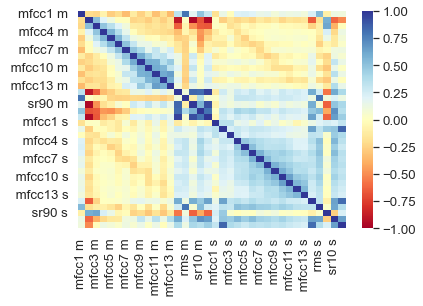

In [ ]:
sns.set(font_scale = 1.2)
sns.heatmap(signal_features.drop(['id','AV', 'MV', 'PV', 'TV', 'Phc'],axis=1).corr(), annot = False,cmap='RdYlBu',vmin=-1.0,vmax=1.0)
plt.show()
# plt.imshow(signal_features.drop(['id','AV', 'MV', 'PV', 'TV', 'Phc'],axis=1).corr())

In [ ]:
df=pd.read_csv(path_db+'patient_info.csv', index_col=0)

In [ ]:
df.columns

Index(['id', '#Age', '#Sex', '#Height', '#Weight', '#Pregnancy status',
       '#Murmur locations', '#Most audible location',
       '#Systolic murmur timing', '#Systolic murmur shape',
       '#Systolic murmur grading', '#Systolic murmur pitch',
       '#Systolic murmur quality', '#Diastolic murmur timing',
       '#Diastolic murmur shape', '#Diastolic murmur grading',
       '#Diastolic murmur pitch', '#Diastolic murmur quality', '#Campaign',
       'frequency', 'num_loc', 'locations', 'label'],
      dtype='object')

In [ ]:
df_nuevo = signal_features.merge(df,on='id')
df_nuevo.head()

,id,AV,MV,PV,TV,Phc,mfcc1 m,mfcc2 m,mfcc3 m,mfcc4 m,...,#Diastolic murmur timing,#Diastolic murmur shape,#Diastolic murmur grading,#Diastolic murmur pitch,#Diastolic murmur quality,#Campaign,frequency,num_loc,locations,label
0,2530,1.0,0.0,0.0,0.0,0.0,-332.599023,58.396291,2.067044,25.910235,...,NaN,NaN,NaN,NaN,NaN,CC2015,4000.0,4,AV+PV+TV+MV,Absent
1,2530,0.0,0.0,1.0,0.0,0.0,-358.497374,108.541063,16.156086,22.845696,...,NaN,NaN,NaN,NaN,NaN,CC2015,4000.0,4,AV+PV+TV+MV,Absent
2,2530,0.0,0.0,0.0,1.0,0.0,-345.393477,78.392506,0.095820,21.307460,...,NaN,NaN,NaN,NaN,NaN,CC2015,4000.0,4,AV+PV+TV+MV,Absent
3,2530,0.0,1.0,0.0,0.0,0.0,-343.073724,58.754784,-17.345502,4.229286,...,NaN,NaN,NaN,NaN,NaN,CC2015,4000.0,4,AV+PV+TV+MV,Absent
4,9979,1.0,0.0,0.0,0.0,0.0,-278.359222,114.038583,4.155783,19.753599,...,NaN,NaN,NaN,NaN,NaN,CC2015,4000.0,4,AV+PV+TV+MV,Present


In [ ]:
df_nuevo['label'].value_counts()

Absent     2391
Present     616
Unknown     156
Name: label, dtype: int64

In [ ]:
2391/3163

0.7559279165349352

In [ ]:
df_nuevo.columns

Index(['id', 'AV', 'MV', 'PV', 'TV', 'Phc', 'mfcc1 m', ' mfcc2 m', ' mfcc3 m',
       ' mfcc4 m', ' mfcc5 m', ' mfcc6 m', ' mfcc7 m', ' mfcc8 m', ' mfcc9 m',
       ' mfcc10 m', ' mfcc11 m', ' mfcc12 m', ' mfcc13 m', ' zcr m', ' rms m',
       ' sr90 m', ' sr10 m', ' sc m', ' mfcc1 s', ' mfcc2 s', ' mfcc3 s',
       ' mfcc4 s', ' mfcc5 s', ' mfcc6 s', ' mfcc7 s', ' mfcc8 s', ' mfcc9 s',
       ' mfcc10 s', ' mfcc11 s', ' mfcc12 s', ' mfcc13 s', ' zcr s', ' rms s',
       ' sr90 s', ' sr10 s', ' sc s', '#Age', '#Sex', '#Height', '#Weight',
       '#Pregnancy status', '#Murmur locations', '#Most audible location',
       '#Systolic murmur timing', '#Systolic murmur shape',
       '#Systolic murmur grading', '#Systolic murmur pitch',
       '#Systolic murmur quality', '#Diastolic murmur timing',
       '#Diastolic murmur shape', '#Diastolic murmur grading',
       '#Diastolic murmur pitch', '#Diastolic murmur quality', '#Campaign',
       'frequency', 'num_loc', 'locations', 'label'],
   